In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
# LOAD MODES 
mode_path = '/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/selected_modes_2deg.nc'
data_modes = xr.open_dataset(mode_path)
lon_in = data_modes.longitude.data
lat_in = data_modes.latitude.data 
z_mode = np.flip(data_modes.z.data)

In [3]:
# LOAD SURFACE VEL
u_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_u_1year.nc'
u_data = xr.open_dataset(u_path)
lon01 = u_data.xu_ocean.data
u_full = np.concatenate((u_data.u_full[:,:,:,lon01 >= 0].data, u_data.u_full[:,:,:,lon01 < 0].data),axis=3)
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = u_data.yu_ocean.data

In [4]:
z = -1*u_data.st_ocean.data

In [5]:
data_modes

<xarray.Dataset>
Dimensions:    (lat: 32, lon: 29, z: 50)
Coordinates:
  * z          (z) float64 5.395e+03 5.185e+03 4.975e+03 ... 25.22 15.1 5.034
  * lat        (lat) int64 2 3 4 5 6 7 8 9 10 11 ... 25 26 27 28 29 30 31 32 33
  * lon        (lon) int64 151 152 153 154 155 156 ... 174 175 176 177 178 179
Data variables:
    modes      (lat, lon, z) float64 ...
    longitude  (lon) int64 302 304 306 308 310 312 ... 348 350 352 354 356 358
    latitude   (lat) int64 -74 -72 -70 -68 -66 -64 ... -22 -20 -18 -16 -14 -12

In [22]:
# extract surface velocity and bottom velocity on modes grid 
skill = np.nan*np.ones(np.shape(data_modes.modes[:,:,0].data))
dep_recon_eval = np.nan*np.ones(np.shape(data_modes.modes[:,:,0].data))
dep_obs_eval = np.nan*np.ones(np.shape(data_modes.modes[:,:,0].data))
for i in range(len(lat_in)):
    for j in range(len(lon_in)):
        this_lon = lon_in[j]
        this_lat = lat_in[i]
        lon2 = np.where((lon1 > (this_lon-1)) & (lon1 < (this_lon+1)))[0]
        lat2 = np.where((lat1 > (this_lat-1)) & (lat1 < (this_lat+1)))[0]
        this_u = np.nanmean(np.nanmean(u_full[:,:,lat2][:,:,:,lon2],axis=2),axis=2)
        this_mode = np.flip(data_modes.modes[i,j,:].data)
        
        if len(np.where(~np.isnan(this_mode))[0]) < 5:
            continue
        
        # -- scale mode by near-surface velocities 
        surf_u = np.nanmean(this_u[:,0:4],axis=1)
        # align with shallowest non-zero mode amp.
        this_recon = np.tile(this_mode,(np.shape(this_u)[0],1))*np.tile(surf_u[:,None]/this_mode[1],(1,len(z)))
        
        # index (above deepest depth) to compute skill 
        indi = 4
        # -- deepest reconstructed velocity 
        good_z = z_mode[np.where(~np.isnan(this_recon[0,:]))[0]]
        bottom_i = np.where(z_mode == np.nanmax(good_z))[0][0]
        bottom_recon_u = np.nanmean(this_recon[:,bottom_i-indi:bottom_i-indi+2],axis=1)
        dep_recon_eval[i,j] = z_mode[bottom_i-indi]
        # -- deepest 'actual' velocity
        bottom_i = np.where(~np.isnan(this_u[0,:]))[0][-1]
        bottom_obs_u = np.nanmean(this_u[:,bottom_i-indi:bottom_i-indi+2],axis=1)
        dep_obs_eval[i,j] = z[bottom_i-indi]
        skill[i,j] = 1 - np.nanvar(bottom_recon_u - bottom_obs_u)/np.nanvar(bottom_obs_u)

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


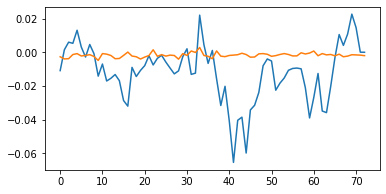

In [154]:
f, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(range(0,len(bottom_obs_u)),bottom_obs_u)
ax.plot(range(0,len(bottom_recon_u)),bottom_recon_u)

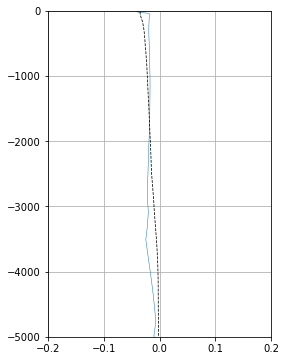

In [155]:
f, ax = plt.subplots(1,1,figsize=(4,6))
for i in range(0,1):
    ax.plot(this_u[i,:],z,linewidth=0.5)
    ax.plot(this_recon[i,:],z,color='k',linestyle='--',linewidth=0.76)
ax.set_xlim([-.2,.2])
ax.set_ylim([-5000,0])
ax.grid()

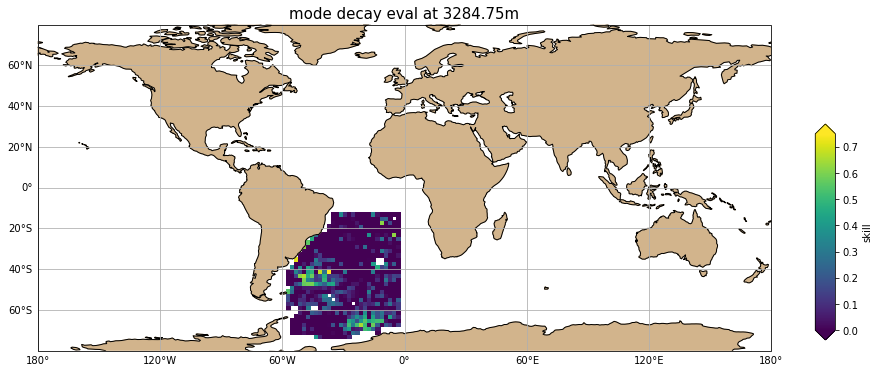

In [23]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmap = plt.get_cmap('viridis')
cc = ax.pcolor(lon_in,lat_in,skill,cmap=cmap,vmin=0,vmax=0.75)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('mode decay eval at ' + str(np.round(np.nanmean(dep_recon_eval),2)) + 'm',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_xlim([-180,180])
ax.set_ylim([-80,80])
cbpos = [0.92, 0.15, 0.02, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='skill', extend='both')
# cb.set_label(label='slope [m/m]', color='k', fontsize=11)

In [144]:
np.nanmax(skill)

0.684494190596534